### Download Data

The code below can be used to download UD corpuses and save them in the work place.  

Due to the limitation of the computer resource, test conllu files are used to illustrate the pipe line of preprocessing, training and evaluation. Thus, the overal everage accuray will be lower than the train conllu data. 

In [2]:
import urllib.request

import requests
print('Download UD corpus for Swedish, English, Finnish, German, Spanish')
print('Beginning file download with requests')

data_urls = ['https://raw.githubusercontent.com/UniversalDependencies/UD_Swedish-PUD/master/sv_pud-ud-test.conllu', 
             'https://raw.githubusercontent.com/UniversalDependencies/UD_English-PUD/master/en_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_Finnish-PUD/master/fi_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_German-PUD/master/de_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-PUD/master/es_pud-ud-test.conllu']

filenames = [url.split("/")[-1] for url in data_urls]

for url, fn in zip(data_urls, filenames):
  urllib.request.urlretrieve(url, fn)


!ls

Download UD corpus for Swedish, English, Finnish, German, Spanish
Beginning file download with requests
Assignment4_tmp.ipynb
Assignment_4_Yongchao_Wu.ipynb
ML_Assignment_4_RNN_based_POS_tagger_v1.ipynb
Pytorch_Practice.ipynb
de_pud-ud-test.conllu
en_pud-ud-test-paug.conllu
en_pud-ud-test.conllu
es_pud-ud-test.conllu
fi_pud-ud-test.conllu
sv_pud-ud-test.conllu


### Create a class that can process and parse UD coll data
The code below will parse UD coll data, extract tokens and relative POS. The code also split the dataset into training and testing for development and test. 

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
import time
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import matplotlib.pyplot as plt
import nlpaug.augmenter.char as nac
import string



class CollProcessor:
    
    def __init__(self):
        pass
    
    
    def load_and_preprocess_conllu(self, file, augment=False):
        X, Y = [], []
        with open(file, "r") as infile:
            sents = infile.read().split("\n\n")
            if sents[-1] == "":
                sents = sents[:-1]
            for sent in sents:
                words, tags = [], []
                lines = sent.split("\n")
                for line in lines:
                    if line.startswith("#"):
                        continue
                    line = line.strip().split("\t")
                    if len(line) >=3:
                        words.append(line[1])
                        tags.append(line[3]) 
                X.append(words)
                Y.append(tags)

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
        # here user can turn on the data augmentation
        if augment:
            aug = nac.OcrAug()
            #for sent in X_train:
                #sent = [aug.augment(x) if x.isalpha() else x for x in sent]
            X_train = [[aug.augment(x) if x.isalpha() else x for x in sent] for sent in X_train]
    
        word2idx = {'<PAD>': 0, '<UNK>': 1}
        tag2idx = dict()
    
        for sentence, tags in zip(X_train, y_train):
            for word in sentence:
                word = word.lower()
                if word not in word2idx:    # The 'in' operator is fast for dictionaries
                    word2idx[word] = len(word2idx)
            for tag in tags:
                if tag not in tag2idx:
                    tag2idx[tag] = len(tag2idx)
        tag2idx['<PAD>'] = len(tag2idx)
        
        idx2word = [None]*len(word2idx)
        for word, idx in word2idx.items():
            idx2word[idx] = word
        idx2tag = [None]*len(tag2idx)
        for tag, idx in tag2idx.items():
            idx2tag[idx] = tag
        
        return X_train, X_test, y_train, y_test, word2idx, tag2idx, idx2tag, idx2word


### Create a Class that can pad and batch data
The code below will pad the data in order to fit into pytorch.  
The the DataLoader is used to batch pytorch data. So all the batched data has the same sentence length in pytorch. 

In [8]:
class DataPadder:
    def __init__(self, sentences, labels, word2idx, tag2idx):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        
    def pad_data(self):
        sentences = self.sentences
        labels = self.labels
        max_len = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
        padded_sentences  = list()
        padded_labels  = list()
        for sentence, tags in zip(sentences, labels):               # Loop over the data
            padded_sentence = [word.lower() if word.lower() in self.word2idx else '<UNK>' for word in sentence]  # Sentence, uses the <UNK> symbol for unknown words
            padded_tags = [tag for tag in tags]                       # Tags
            while len(padded_sentence) < max_len:                     # Adds padding to the sequences 
                padded_sentence.append('<PAD>')
                padded_tags.append('<PAD>')
            padded_sentences.append(padded_sentence)                  # Append the processed sample to the output
            padded_labels.append(padded_tags)
        return padded_sentences, padded_labels

    def encode_data(self):
        padded_sentences, padded_labels = self.pad_data()
        tag2idx = self.tag2idx
        word2idx = self.word2idx
        encoded_sentences = list()
        for padded_sentence in padded_sentences:
            encoded_sentences.append([word2idx[word] for word in padded_sentence])
        encoded_labels = list()
        for padded_tags in padded_labels:
            encoded_labels.append([tag2idx[tag] for tag in padded_tags])
        return torch.LongTensor(encoded_sentences), torch.LongTensor(encoded_labels)

# here we use the Dataset and DataLoader to make the data looped by pythorch easier in the future. 
    def batch_data(self, batch_size):
        features, labels = self.encode_data()
        dataset = Data.TensorDataset(features, labels)
        data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)
        return data_iter
        
    

### Tagger Class

The tagger class contains LSTM/GRU model related hyperparameters. 

In [9]:
import time
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Tagger(nn.Module):
  def __init__(self, model, word_embedding_dim, hidden_dim, vocabulary_size, tagset_size, dropout, bidirectional, word2idx):
    """
    
    word_embedding_dim
      The dimensionality of the word embedding
    hidden_dim
      The dimensionality of the ...
    vocabulary_size
      The size of the vocabulary (i.e. the number of unique words in the word embedding)
    tagset_size
    """
    super(Tagger, self).__init__() # We need to initialise the class we are inheriting from
    self.model = model
    self.hidden_dim = hidden_dim                             # This simply stores the parameter
    self.vocabulary_size = vocabulary_size
    self.tagset_size = tagset_size
    self.dropout = dropout
    self.bidirectional = bidirectional
    self.word2idx = word2idx
    self._word_embeddings = nn.Embedding(num_embeddings=vocabulary_size,     # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=self.word2idx['<PAD>'])
    if model == "LSTM":
        self._lstm = nn.LSTM(input_size=word_embedding_dim,                 # The Tagger takes an embedded sentence as input, and outputs 
                              hidden_size=hidden_dim,                   # vectors with dimensionality hidden_dim.
                              batch_first=True,
                              bidirectional=bidirectional, 
                              dropout=dropout,
                              num_layers=2)
    elif model == "GRU":
        self._gru = nn.GRU(input_size=word_embedding_dim,                 # The Tagger takes an embedded sentence as input, and outputs 
                              hidden_size=hidden_dim,                   # vectors with dimensionality hidden_dim.
                              batch_first=True,
                              bidirectional=bidirectional, 
                              dropout=dropout,
                              num_layers=2)

    
    self._hidden2tags = nn.Linear(hidden_dim, tagset_size)         # The linear layer maps from the RNN output space to tag space
                                      
  def forward(self, padded_sentences):
    """The forward pass through the network"""

    batch_size, max_sentence_length = padded_sentences.size()
    
    embedded_sentences = self._word_embeddings(padded_sentences) 

    X = embedded_sentences

    tag_space = self._hidden2tags(X)

    # The output from the LSTM/GRU layer is flattened and passed to the fully 
                                                                        # connected layer.
    tag_scores = F.log_softmax(tag_space, dim=1)                        # Softmax is applied to normalise the outputs

    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size)




### Pipe Class. 
This class is mainly used for tuning and carry different test. The pipe class itself is quite small and clean.

In [10]:
class pipe:
    
    def __init__(self):
        
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.word2idx = None
        self.tag2idx = None
        self.idx2tag = None
        self.idx2word = None
        
        self.data_iter = None
        self.data_iter_test = None 
        
        self.tagger = None
        
    def get_word2idx(self):
        return self.word2idx
        
    def pre_process(self, file, augment=False):
        
        coll_processor = CollProcessor()
        self.X_train, self.X_test, self.y_train, \
        self.y_test, self.word2idx, self.tag2idx, \
        self.idx2tag, self.idx2word \
        = coll_processor.load_and_preprocess_conllu(file, augment)
        print("Using corpus: ", file)
        print("There are overal", len(self.X_train)+len(self.X_test), "sentences in the corpus.")
        
    def pad_and_batch(self, batch_size ):
        data_padder = DataPadder(self.X_train, self.y_train, self.word2idx, self.tag2idx)
        self.data_iter = data_padder.batch_data(batch_size = batch_size)
        data_padder2 = DataPadder(self.X_test, self.y_test, self.word2idx, self.tag2idx)
        self.data_iter_test = data_padder2.encode_data()
        
    def create_tagger(self, model, WORD_EMBEDDING_DIM, HIDDEN_DIM, dropout, bidirectional, word2idx, printout=False):
        self.tagger = Tagger(model=model,word_embedding_dim=WORD_EMBEDDING_DIM, 
                        hidden_dim=HIDDEN_DIM,
                        vocabulary_size=len(self.word2idx),                            # The vocabulary incudes both the 'padding' and 'unknown' symbols
                        tagset_size=len(self.tag2idx)-1, 
                        dropout=dropout,
                        bidirectional=bidirectional,
                        word2idx=word2idx)
        if printout:
            print("The tagger is based on ",model, ", its network details can be summarized as below:")
            print(self.tagger)
        
    def train_the_tagger(self, learning_rate, weight_decay, epoch_num, plotout=False):
        loss_function = nn.NLLLoss(ignore_index=self.tag2idx['<PAD>'])
        optimizer = optim.Adam(self.tagger.parameters(), lr=learning_rate, weight_decay=weight_decay)
        loss_for_plotting = list()
        start_t = time.time()
        for epoch in range(epoch_num):
            for inputs, targets in self.data_iter: # Now for looping over the training data
                self.tagger.zero_grad()                                       # Reset gradients
                tag_scores = self.tagger(inputs)                              # Forward pass
                tag_scores = tag_scores.view(-1, self.tagger.tagset_size)     # Resize to get tag probabilities along a separate dimension
                                                                    # but flatten all the different sentences
                targets = targets.view(-1)                              # Flatten y
                loss = loss_function(tag_scores, targets)               # Get loss
                loss.backward()                                         # Backpropagate the error
                optimizer.step()                                        # Run the optimizer to change the weights w.r.t the loss
                loss_for_plotting.append(loss.item())                   # Save the loss for plotting
        print("Epoch %i: loss=%.3f, taining time=%.1fs" % (epoch_num, loss, time.time()-start_t))
        
        if plotout:
            plt.figure()
            plt.title("Plot for the (hopefully) decreasing loss over epochs")
            plt.plot(loss_for_plotting, '.-')
            plt.xlabel("Batch")
            plt.ylabel("Loss")
            plt.show()
        
    def tag_mean_accuracy(self, y, y_hat):
        accuracy = list()
        for u, v in zip(y, y_hat):
            accuracy.append(np.sum([e1==e2 for e1, e2 in zip(u, v)])/len(u))
        return np.mean(accuracy), np.std(accuracy)
    
    def evaluate_tagger(self):
        
        with torch.no_grad():
            inputs, _ = self.data_iter_test                   # The test data must be in the allowed input format
            tag_scores = self.tagger(inputs)                                        # Runs the test data through the model
            tag_idx = np.asarray(np.argmax(tag_scores.numpy(), axis=2), dtype=np.int) # Get the most likely tag indeces
            y_hat = list()                                                    # The model predicts indeces but we want tags
            for i in range(tag_scores.shape[0]):                              # Loop over test samples
                padding_mask = inputs[i, :] != self.word2idx['<PAD>']                # Prepare to mask out padding
                y_hat.append([self.idx2tag[e] for e in tag_idx[i, padding_mask]])    # Remove padding and transform to tags

        accuracy, sigma = self.tag_mean_accuracy(self.y_test, y_hat)
        print("Mean accuracy: %.1f%% [std %.1f%%]" % (100*accuracy, 100*sigma))

            
        

### A small demo for pipe usage

Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
The tagger is based on  GRU , its network details can be summarized as below:
Tagger(
  (_word_embeddings): Embedding(5045, 64, padding_idx=0)
  (_gru): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (_hidden2tags): Linear(in_features=64, out_features=17, bias=True)
)
Epoch 30: loss=1.253, taining time=3.3s


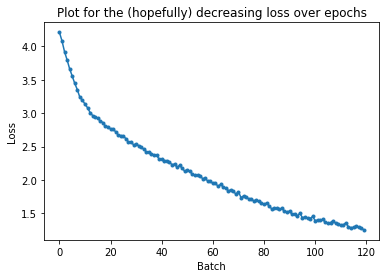

Mean accuracy: 71.9% [std 10.4%]


In [11]:
# hyperparameters are placed together, thus it is easier to tune the model.
batch_size = 250
WORD_EMBEDDING_DIM = 64
HIDDEN_DIM = 64
dropout = 0.1
bidirectional = True
model = "GRU"
learning_rate=0.01
weight_decay = 0.0001
epoch_num = 30

# The pipe class usage demo
newpipe = pipe()
newpipe.pre_process(file='en_pud-ud-test.conllu')
word2idx = newpipe.get_word2idx()
newpipe.pad_and_batch(batch_size=batch_size)

newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout, bidirectional=bidirectional, model=model, word2idx = word2idx, printout=True)
newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = weight_decay, epoch_num = epoch_num, plotout=True)
newpipe.evaluate_tagger()

### Experiment A test to study relation between model complexity and accuracy. Using English corpus.

In [14]:
batch_size = 250
DIM = [(16, 16), (32, 32), (64, 64), (128, 128)]
dropout = 0.1
bidirectional = True
model = "GRU"
learning_rate=0.01
weight_decay = 0.0001
epoch_num = 30
corpus = 'en_pud-ud-test.conllu'

for WORD_EMBEDDING_DIM, HIDDEN_DIM in DIM:
    newpipe = pipe()
    newpipe.pre_process(file=corpus)
    word2idx = newpipe.get_word2idx()
    newpipe.pad_and_batch(batch_size=batch_size)

    newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout, bidirectional=bidirectional, model=model, word2idx = word2idx, printout=True)
    newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = weight_decay, epoch_num = epoch_num)
    newpipe.evaluate_tagger()
    
    print("\n")
    

Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
The tagger is based on  GRU , its network details can be summarized as below:
Tagger(
  (_word_embeddings): Embedding(5045, 16, padding_idx=0)
  (_gru): GRU(16, 16, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (_hidden2tags): Linear(in_features=16, out_features=17, bias=True)
)
Epoch 30: loss=1.649, taining time=3.4s
Mean accuracy: 70.7% [std 10.8%]


Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
The tagger is based on  GRU , its network details can be summarized as below:
Tagger(
  (_word_embeddings): Embedding(5045, 32, padding_idx=0)
  (_gru): GRU(32, 32, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (_hidden2tags): Linear(in_features=32, out_features=17, bias=True)
)
Epoch 30: loss=1.374, taining time=3.5s
Mean accuracy: 71.8% [std 11.0%]


Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corp

### Experiment: A test to study relation between model complexity and accuracy. Using English, Spannish, German, French, Finnish Corpus.

In [17]:
for corpus in filenames:
    newpipe = pipe()
    newpipe.pre_process(file=corpus)
    word2idx = newpipe.get_word2idx()
    newpipe.pad_and_batch(batch_size=batch_size)

    newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout, bidirectional=bidirectional, model=model, word2idx = word2idx)
    newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = weight_decay, epoch_num = epoch_num)
    newpipe.evaluate_tagger()
    
    print("\n")


Using corpus:  sv_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.162, taining time=3.6s
Mean accuracy: 73.1% [std 11.5%]


Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.244, taining time=4.0s
Mean accuracy: 74.9% [std 10.8%]


Using corpus:  fi_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.215, taining time=3.4s
Mean accuracy: 59.6% [std 12.5%]


Using corpus:  de_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.266, taining time=4.4s
Mean accuracy: 69.0% [std 11.0%]


Using corpus:  es_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.393, taining time=4.8s
Mean accuracy: 80.0% [std 9.5%]




### Experiment Trial of data augmentation using `nlpaug`

In [18]:

!cp en_pud-ud-test.conllu en_pud-ud-test-paug.conllu
!ls



Assignment4_tmp.ipynb
Assignment_4_Yongchao_Wu.ipynb
ML_Assignment_4_RNN_based_POS_tagger_v1.ipynb
Pytorch_Practice.ipynb
de_pud-ud-test.conllu
en_pud-ud-test-paug.conllu
en_pud-ud-test.conllu
es_pud-ud-test.conllu
fi_pud-ud-test.conllu
sv_pud-ud-test.conllu


In [19]:
conllu_p = CollProcessor()
X_train_t, X_test_t, y_train_t, y_test_t, word2idx_T, tag2idx_t, idx2tag_t, idx2word_t = conllu_p.load_and_preprocess_conllu(file='en_pud-ud-test-paug.conllu', augment=True)
print (X_train_t[1])
conllu_p = CollProcessor()
X_train_t, X_test_t, y_train_t, y_test_t, word2idx_T, tag2idx_t, idx2tag_t, idx2word_t = conllu_p.load_and_preprocess_conllu(file='en_pud-ud-test-paug.conllu', augment=False)
print (X_train_t[1])


['Oozens', 'uf', 'F8LN', 'fol1uwers', 'ake', 'a1keady', 'ce1ebkatin9', 'the', 'vict0ky', 'in', 'the', 'P1aza', 'de', 'la8', 'Victuria8', '.']
['Dozens', 'of', 'FSLN', 'followers', 'are', 'already', 'celebrating', 'the', 'victory', 'in', 'the', 'Plaza', 'de', 'las', 'Victorias', '.']


Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
The tagger is based on  GRU , its network details can be summarized as below:
Tagger(
  (_word_embeddings): Embedding(6316, 64, padding_idx=0)
  (_gru): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (_hidden2tags): Linear(in_features=64, out_features=17, bias=True)
)
Epoch 30: loss=1.314, taining time=3.5s


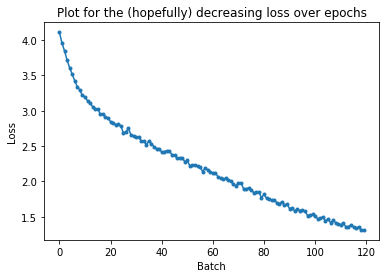

Mean accuracy: 34.7% [std 10.6%]


In [20]:
# hyperparameters are placed together, thus it is easier to tune the model.
batch_size = 250
WORD_EMBEDDING_DIM = 64
HIDDEN_DIM = 64
dropout = 0.1
bidirectional = True
model = "GRU"
learning_rate=0.01
weight_decay = 0.0001
epoch_num = 30

# The pipe class usage demo
newpipe = pipe()
newpipe.pre_process(file='en_pud-ud-test.conllu', augment=True)
word2idx = newpipe.get_word2idx()
newpipe.pad_and_batch(batch_size=batch_size)

newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout, bidirectional=bidirectional, model=model, word2idx = word2idx, printout=True)
newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = weight_decay, epoch_num = epoch_num, plotout=True)
newpipe.evaluate_tagger()

### Experiment with Dropout

In [23]:
# hyperparameters are placed together, thus it is easier to tune the model.
batch_size = 250
WORD_EMBEDDING_DIM = 64
HIDDEN_DIM = 64
dropout = [0, 0.1, 0.3, 0.5]
bidirectional = True
model = "GRU"
learning_rate=0.01
weight_decay = 0.0001
epoch_num = 30

for dropout_value in dropout:
    print("drop out value", dropout_value)

    newpipe = pipe()
    newpipe.pre_process(file='en_pud-ud-test.conllu')
    word2idx = newpipe.get_word2idx()
    newpipe.pad_and_batch(batch_size=batch_size)

    newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout_value, bidirectional=bidirectional, model=model, word2idx = word2idx, printout=False)
    newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = weight_decay, epoch_num = epoch_num, plotout=False)
    newpipe.evaluate_tagger()
    
    print("\n")

drop out value 0
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.301, taining time=3.4s
Mean accuracy: 72.9% [std 9.9%]


drop out value 0.1
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.287, taining time=3.5s
Mean accuracy: 74.4% [std 10.2%]


drop out value 0.3
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.262, taining time=3.5s
Mean accuracy: 74.4% [std 9.6%]


drop out value 0.5
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.293, taining time=3.5s
Mean accuracy: 72.6% [std 11.0%]




### Experiment with Weight Decay

In [24]:
# hyperparameters are placed together, thus it is easier to tune the model.
batch_size = 250
WORD_EMBEDDING_DIM = 64
HIDDEN_DIM = 64
dropout = 0.1
bidirectional = True
model = "GRU"
learning_rate=0.01
weight_decay = [0, 0.0001, 0.001, 0.01]
epoch_num = 30

for wd_value in weight_decay:
    print("weight decay", wd_value)

    newpipe = pipe()
    newpipe.pre_process(file='en_pud-ud-test.conllu')
    word2idx = newpipe.get_word2idx()
    newpipe.pad_and_batch(batch_size=batch_size)

    newpipe.create_tagger(WORD_EMBEDDING_DIM=WORD_EMBEDDING_DIM, HIDDEN_DIM=HIDDEN_DIM, dropout=dropout, bidirectional=bidirectional, model=model, word2idx = word2idx, printout=False)
    newpipe.train_the_tagger(learning_rate = learning_rate, weight_decay = wd_value, epoch_num = epoch_num, plotout=False)
    newpipe.evaluate_tagger()
    print("\n")

weight decay 0
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.136, taining time=3.3s
Mean accuracy: 68.3% [std 10.0%]


weight decay 0.0001
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=1.284, taining time=3.4s
Mean accuracy: 73.2% [std 10.0%]


weight decay 0.001
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=2.268, taining time=3.4s
Mean accuracy: 62.5% [std 9.4%]


weight decay 0.01
Using corpus:  en_pud-ud-test.conllu
There are overal 1000 sentences in the corpus.
Epoch 30: loss=2.847, taining time=3.5s
Mean accuracy: 48.0% [std 10.2%]




## Submission

1. A working implementation of your pipeline, reproducing your principal results when executed.

  Done.
  

2. Comments in the code for longer or opaque functionality. Please try to write self documenting code (e.g. by choosing descriptive variables names etc).

  Done.  

3. A *brief* description of the implementation work that was necessary to complete the different parts, showing how you arrived at your solution.

  Done.  
  
  First I implement classes that can handle different tasks(preprocessing, padding, batching, tagger model), then create a pipe class that includes the small classes. The advantage is that, this way will create a small and clean size of pipe line class. All hyperparameters are held in one place which will help us to tune the model easily. 

4. The given model refactored as a class (including relevant preprocessing, forward/backward pass etc).

  Done.
  
  Same explaination as point 3. A short demo of pipe is showed in the above code cell. 

5. Not all languages require the same model complexity for POS tagging. Some might need a higher dimensionality for the embedding or layers for the model to perform well. What is the relation between model complexity and accuracy? Include a quantitative evaluation of data in five languages from the [universal dependencies](https://universaldependencies.org/) project (UD). These will be on the familiar conll format. Parse the files to get the words (not lemmas) and universal tags.

  Done.
  
  For this part, 5 language UD Corpuses are used in the analysis(Spannish, English, German, Finnish, and Frech.)
We can see that, with model complexity dimension increasing, at first the accuracy is increasing but then dropped a little bit. That means with a "proper" complexity dimension model, the accuracy can be improved. But if the complexity is too large, the model itself will not be trained properly, thus, the accuracy will not be improved.   

  And we can see that, with same settings of model complexity, different language behaves differently. The result shows that Finnish performs a poor tagging accuracy because of a more rich language mophology nature. While for spannish and English, the accracy is higher.   

  Note, because UD coll corpus only contains 1000 sentences. The overal result is not that high.   

7. Comments on what you thought was hard in the assignment, what you think was educational, what took most time and which parts might be unnecessary tricky.

  Done.   

  I like this assignment. I learned a lot from the implementation of LSTM and GRU using pytorch and find pytorch is very powerful and convenient. I also learned a lot from refactoring the code from distributed functions into classes, which makes me think a lot about how to organize the machine learning code, how to arrange the hyperparameters to make the tuning easier. 

### Extensions
 
To get a passing grade (G), you should (in addition to the above stated points) extend the given model in at least three of the following ways. For a pass with distinction grade (VG), you should extend your analysis to include all of the following points. State clearly which ones you have done.
 
1. There are other types of RNNs layers commonly used in NLP. Add the option to use a GRU layer instead of LSTM, and include this in your performance comparison.

    Done.     
    The code details is in class `Tagger`.  The `Tagger` has both options for LSTM and GRU.  
    <br>
2. The given implementation only allows for dependencies from left to right. Add the option to use a bi-directional pass in the RNN layer.

    Done.     
    The code details is in class `Tagger`.  bi-directional parameter is added.  
    <br>  
3. Use pytorch's `Dataset` and `DataLoader` classes for loading the data. [This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a good starting point. This should make it easier to loop over data sets.
    
    Done.  
    The code details is in class `DataPadder`.   `Dataset` and `DataLoader` are used to easily batch and loop data.  
    <br>    
4. Try some type of data augmentation in your training data. This should theoretically increase the generalisability of your model. See if this is true for your chosen data sources. How much augmentation is too much?

    Done.  
    NLP data augmentation library `nlpaug` is used to do the data augmentation. Simple change word spellings. For  example, after apply the data augmentation, the sentence looks like below:
    `['Do2ens', '0f', 'F8LN', 'fol1uwers', 'ake', 'a1keady', 'ce1e6ratin9', 'the', 'vict0ky', 'in', 'the', 'Pla2a', 'de', '1as', 'Victokia8', '.']`
     `['Dozens', 'of', 'FSLN', 'followers', 'are', 'already', 'celebrating', 'the', 'victory', 'in', 'the', 'Plaza', 'de', 'las', 'Victorias', '.'] `
     But the result shows a lower accuray, which means the augmentation is too much. because there are too many unkown words after the augmentation and the tagger just makes wrong prediction. 
    More details could be referred to the code cell `Trial of data augmentation using nlpaug`. How to use turn on the data augmentation function should be referred to the class `CollProcessor`, there is a option `augment`. 
    
    <br>    
5. Implement some level of dropout in your model. See if dropout has any effect on the generalisability of your model. This can be implemeted in several ways, *briefly* argue or the choices you made.
    
    Done.  
    In this work, dropout is just easily used the embedded pytorch dropout in lstm/gnu.  
    According to the pytorch document. dropout here introduces a Dropout layer on the outputs of each LSTM/GNU layer except the last layer, with dropout probability equal to dropout. That means, if we want to use dropout in LSTM/GNU, layer network layer should be lager than 1, so we just set the `Num_layers=2` to enable dropout. From the Experiment Cell we can see that, due to the limiation of the dataset, the overal accuracy is not good. While with a small dropout value, the accuracy imporved a bit. But if the dropout value is too big, the accuracy will be lower. 
    
    <br>    
6. Add more sources. You can either add more sources from one language but with different types of text or simply more languages. An interesting thing to try could be how languages with very different levels of morphology (e.g. english vs finish) requires more or less training data. The total number of sources should be above 15.

    Done.  
    Similar Analysis can be found in the code cell `Experiment: A test to study relation between model complexity and accuracy. Using English, Spannish, German, French, Finnish Corpus`. We can see that The result shows that Finnish performs a poor tagging accuracy because of a more rich language mophology nature. While for spannish and English, the accracy is higher. Thus, to reach same level of accuracy for language like Finnish, more complex model or more training data is needed. 
    If we want to add more language resources, just add the url in the file downloading code block:
    ```
  data_urls = ['https://raw.githubusercontent.com/UniversalDependencies/UD_Swedish-PUD/master/sv_pud-udtest.conllu', 
             'https://raw.githubusercontent.com/UniversalDependencies/UD_English-PUD/master/en_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_Finnish-PUD/master/fi_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_German-PUD/master/de_pud-ud-test.conllu',
             'https://raw.githubusercontent.com/UniversalDependencies/UD_Spanish-PUD/master/es_pud-ud-test.conllu']
             'more files'
             
    ```
    <br>    
7. Comment on shortcomings and how to improve the model more in line with the state-of-the-art. References to the relevant literature (a good starting point is [NLP-progress](http://nlpprogress.com/).

    Done.    
    The process of encoding the input as a fixed-size state vector (hidden state) is actually a process of "information lossy compression". If the amount of information is larger, the loss of information caused by the process of converting vectors is greater. What the attention model needs to do is to encode the encoder into different Context according to each time step of the sequence. When decoding, combine each different Context to decode the output, so that the result obtained will be more accurate.  
    Ref:
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan NGomez, Łukasz Kaiser, and Illia Polosukhin. Attention is All you Need. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R. Garnett, editors, Advances in Neural Information Processing Systems 30, pages 5998–6008. Curran Associates, Inc., 2017.  
    
   <br>      
8. Examine how weight decay is implemented in pytorch and if it improves your model.
    
   Done.  
   Weight decay in pytorch is implemented in different optimizer. In this assignment, the optimizer is torch.optim.Adam. In this optimizer, weight decay is implemented as L2 regularization. The experiment of weight decay can be referred in the code bock `Experiment with weight decay.` With a proper `weight decay`, the model accuracy will be improved. 
    <br>